In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 20]
import sys
import numpy as np
import pandas as pd
import matplotlib

## Water Contamination Data

Our water contamination data set from EPA consists of two CSVs: UCMR3_All_Tribes_AK_LA.csv and UCMR3_All_MA_WY.csv. We will combine these CSVs into a single dataframe and perform some preprocessing - preprocessing steps include merging in UCMR3_ZipCodes.csv, merging in latitude/longitude, and transforming our boolean result variable into an easily processable state (without transformation '<' indicates below contamination threshold, and '='indicates at or above the contamination threshold).

In [41]:
def read_file(fname, sep=','):
    df = pd.read_csv('data/{}'.format(fname), sep=sep, encoding='utf-8')
    return df

def join_zip_codes(df):
    '''Merge zip code data set into UCMR3 data set'''
    zip_codes = read_file('UCMR3_ZipCodes.csv')
    df.set_index('PWSID').join(zip_codes.set_index('PWSID'))
    df = df.merge(zip_codes, how='left')
    df = df.rename(columns={'ZIPCODE': 'Zip'})
    df = df.drop(['PWSID'], axis=1)
    #df = df.dropna()
    df['Zip']=df['Zip'].astype(str)
    return df

def join_lat_long(df):
    '''Merge lat/long data set into UCMR3 data set'''
    zip_codes = read_file('UCMR3_ZipCodes.csv')
    lat_long = read_file('us-zip-code-latitude-and-longitude.csv', sep=';')
    lat_long = lat_long.drop(['Timezone', 'Daylight savings time flag', 'geopoint', 'City', 'State'], 1)
    lat_long['Zip']=lat_long['Zip'].astype(str)
    df.set_index('Zip').join(lat_long.set_index('Zip'))
    df = df.merge(lat_long, how='left')
    return df

def transform_results_sign(df):
    '''
    Convert results sign (where < indicates levels below minimum reporting level and = indicates above)
    Drops any rows that are not classified as either < or =
    '''
    print(df.size)
    results_sign = pd.DataFrame([['<', 0], ['=', 1]], columns=['AnalyticalResultsSign', 'IsContaminated'])
    df.set_index('AnalyticalResultsSign').join(results_sign.set_index('AnalyticalResultsSign'))
    df = df.merge(results_sign, how='left')
    print(df.size)
    df = df.drop(['AnalyticalResultsSign','AnalyticalResultValue'], 1)
    return df

def convert_datetime(df, cols):
    for col in cols:
        df[col] = pd.to_datetime(df[col])
    return df

def transform_size(df):
    '''
    Converts size (where L is large and S is small) to bool
    '''
    size = pd.DataFrame([['L', 0], ['S', 1]], columns=['Size', 'SizeBool'])
    df.set_index('Size').join(size.set_index('Size'))
    df = df.merge(size, how='left')
    df = df.drop(['Size'], 1)
    return df

def get_contamination_df():
    frames = []
    for f in ['UCMR3_All_Tribes_AK_LA.csv', 'UCMR3_All_MA_WY.csv']:
        df = read_file(f)
        df = df[['PWSID', 'Size', 'FacilityID', 'FacilityWaterType', 'CollectionDate', 'Contaminant', 
                 'AnalyticalResultsSign', 'AnalyticalResultValue', 'State']]
        df = join_zip_codes(df)
        df = join_lat_long(df)
        df = transform_results_sign(df)
        df = transform_size(df)

        df = convert_datetime(df, ['CollectionDate'])
        #return df
        frames.append(df)
    df = pd.concat(frames).reset_index()
    return df

In [42]:
wc = get_contamination_df()
wc.head()

34681383
37834236


/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


33460427
36502284


,index,FacilityID,FacilityWaterType,CollectionDate,Contaminant,State,Zip,Latitude,Longitude,IsContaminated,SizeBool
0,0,90002,GW,2015-01-12,molybdenum,LA,70612,30.264232,-93.326527,0,0
1,1,90002,GW,2015-01-12,"1,2,3-trichloropropane",LA,70612,30.264232,-93.326527,0,0
2,2,90002,GW,2015-01-12,chromium,LA,70612,30.264232,-93.326527,0,0
3,3,90002,GW,2015-01-12,strontium,LA,70612,30.264232,-93.326527,1,0
4,4,90002,GW,2015-01-12,chromium-6,LA,70612,30.264232,-93.326527,1,0


We want to see how many contaminants we can expect to see in samples collected from a facility date at any point in time, and we want to see this across all facilities/collection dates.

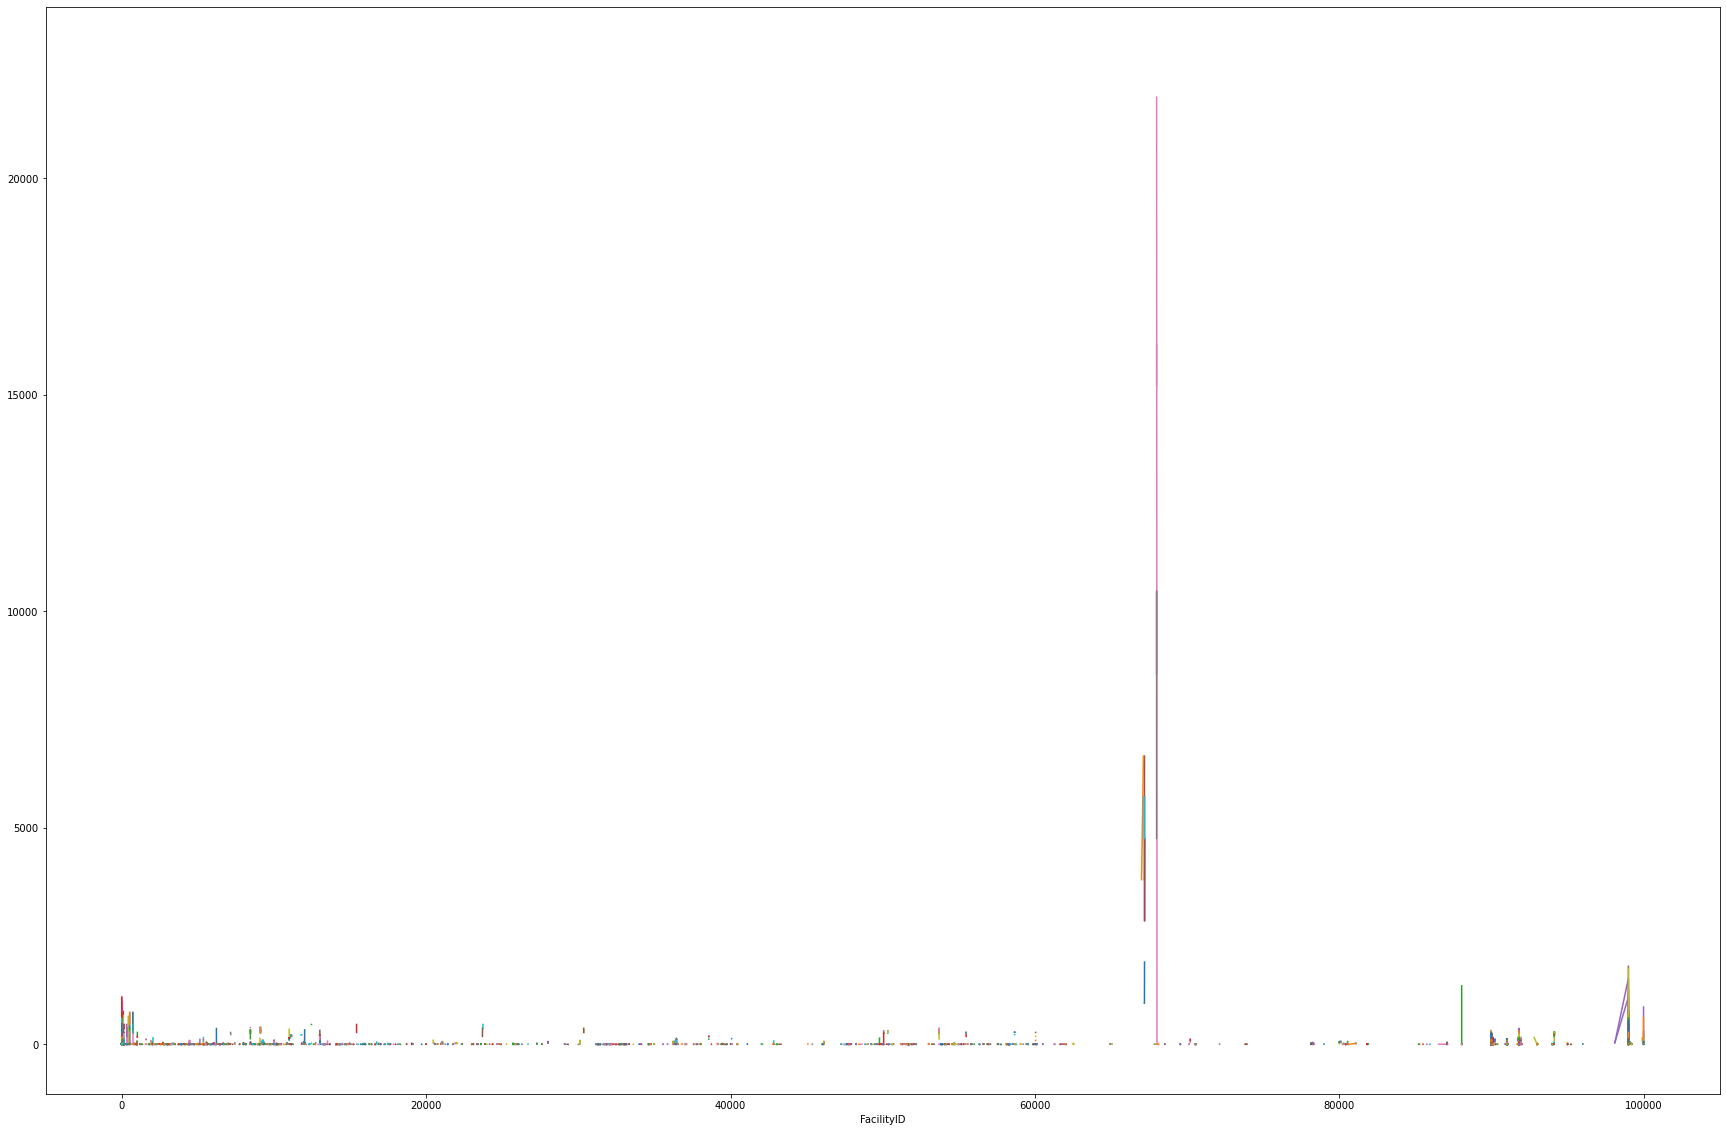

In [43]:
wc_facility_sample_ccount = wc.groupby(['FacilityID','CollectionDate'])['IsContaminated'].sum().reset_index()
wc_graph = wc_facility_sample_ccount.set_index(['CollectionDate', 'FacilityID']).IsContaminated.unstack(-2)
wc_graph.plot(legend=False)
plt.show()

We can see there are samples taken at a single facility over the course of several days (as a single color indicates a combination of facility ID & collection date). We don't want to count all contaminants detected on all days. Rather, we want count the unique contaminants across all samples taken together so that a single entry in our dataframe is indicative of a single "event". Below we see that water sampling tends to go on for as long as a month.

In [44]:
wc_facility_sample_ccount[(wc_facility_sample_ccount['FacilityID']==1) & 
                          (wc_facility_sample_ccount['CollectionDate'].dt.month==1)]

,FacilityID,CollectionDate,IsContaminated
0,1,2013-01-03,368
1,1,2013-01-07,10
2,1,2013-01-08,26
3,1,2013-01-09,1
4,1,2013-01-10,10
5,1,2013-01-14,3
6,1,2013-01-15,26
7,1,2013-01-16,33
8,1,2013-01-17,10
9,1,2013-01-18,4


FacilityID is non-unique - it can repeat across states

In [45]:
wc.loc[wc['FacilityID'] == 1].State.unique()

array(['NN', 'CA', 'CO', 'DC', 'FL', 'AR', '9', 'KS', 'ID', 'IA', 'HI',
       'KY', 'AL', 'MD', 'MN', 'MA', 'NC', 'NH', 'TN', 'PA', 'PR', 'SD',
       'RI', 'WA', 'VT', 'VI', 'WI', 'UT', 'OR', 'NY', 'NE'], dtype=object)

Let's group together windows of 40 days, and count the number of unique contaminants seen for those groups.

In [46]:
# wc_cleaned is the total number of unique contaminants seen in a facility given that sampling at a facility
# can happen over a course of up to 50 days
wc_cleaned = (wc.groupby([pd.Grouper(key='CollectionDate', freq='50D'), 'FacilityID', 'State'])['Contaminant']
             .nunique()
             .reset_index()
             .rename(columns={'Contaminant':'ContaminantCount'}))
print(wc_cleaned.columns)


# wc_collapsed groups the data the same way as wc_cleaned, but retains other facility information like
# zipcode, latitude, longitude, state
wc_collapsed = wc.groupby([pd.Grouper(key='CollectionDate', freq='50D'), 'FacilityID', 'State']).first().reset_index()
# update wc_cleaned by joining with wc_collapsed so that we retain richness of our dataset
wc_cleaned = wc_cleaned.merge(wc_collapsed, on=['CollectionDate','FacilityID', 'State'], how='left').reset_index()
# drop the contaminant column, since at an aggregate level, there is no "one" contaminant
wc_cleaned.drop('Contaminant', axis=1, inplace=True)

#drop any columns with nan in latitude/longitude
wc_cleaned = wc_cleaned[(wc_cleaned['Latitude'].notnull()) & (wc_cleaned['Longitude'].notnull())]

wc_cleaned.head()

Index(['CollectionDate', 'FacilityID', 'State', 'ContaminantCount'], dtype='object')


,level_0,CollectionDate,FacilityID,State,ContaminantCount,index,FacilityWaterType,Zip,Latitude,Longitude,IsContaminated,SizeBool
0,0,2013-01-02,1,AR,26,3068079,GW,71671,33.608004,-92.081010,0,1
1,1,2013-01-02,1,CA,28,183419,SW,94523,37.951672,-122.073170,0,0
2,2,2013-01-02,1,CO,28,98097,SW,80234,39.909100,-105.008290,0,0
3,3,2013-01-02,1,FL,28,256297,GW,33563,28.016971,-82.128584,1,0
4,4,2013-01-02,1,IA,21,288731,GW,50010,42.029330,-93.609660,0,0


In [47]:
wc_cleaned.loc[wc_cleaned['FacilityID'] == 1,['CollectionDate','FacilityID','ContaminantCount','State']].head(30)

,CollectionDate,FacilityID,ContaminantCount,State
0,2013-01-02,1,26,AR
1,2013-01-02,1,28,CA
2,2013-01-02,1,28,CO
3,2013-01-02,1,28,FL
4,2013-01-02,1,21,IA
5,2013-01-02,1,21,ID
6,2013-01-02,1,28,KY
7,2013-01-02,1,21,MA
8,2013-01-02,1,26,NE
9,2013-01-02,1,21,NH


We see that the number of unique contaminantis somewhere between 0 and 40.

array([[<AxesSubplot:title={'center':'ContaminantCount'}>]], dtype=object)

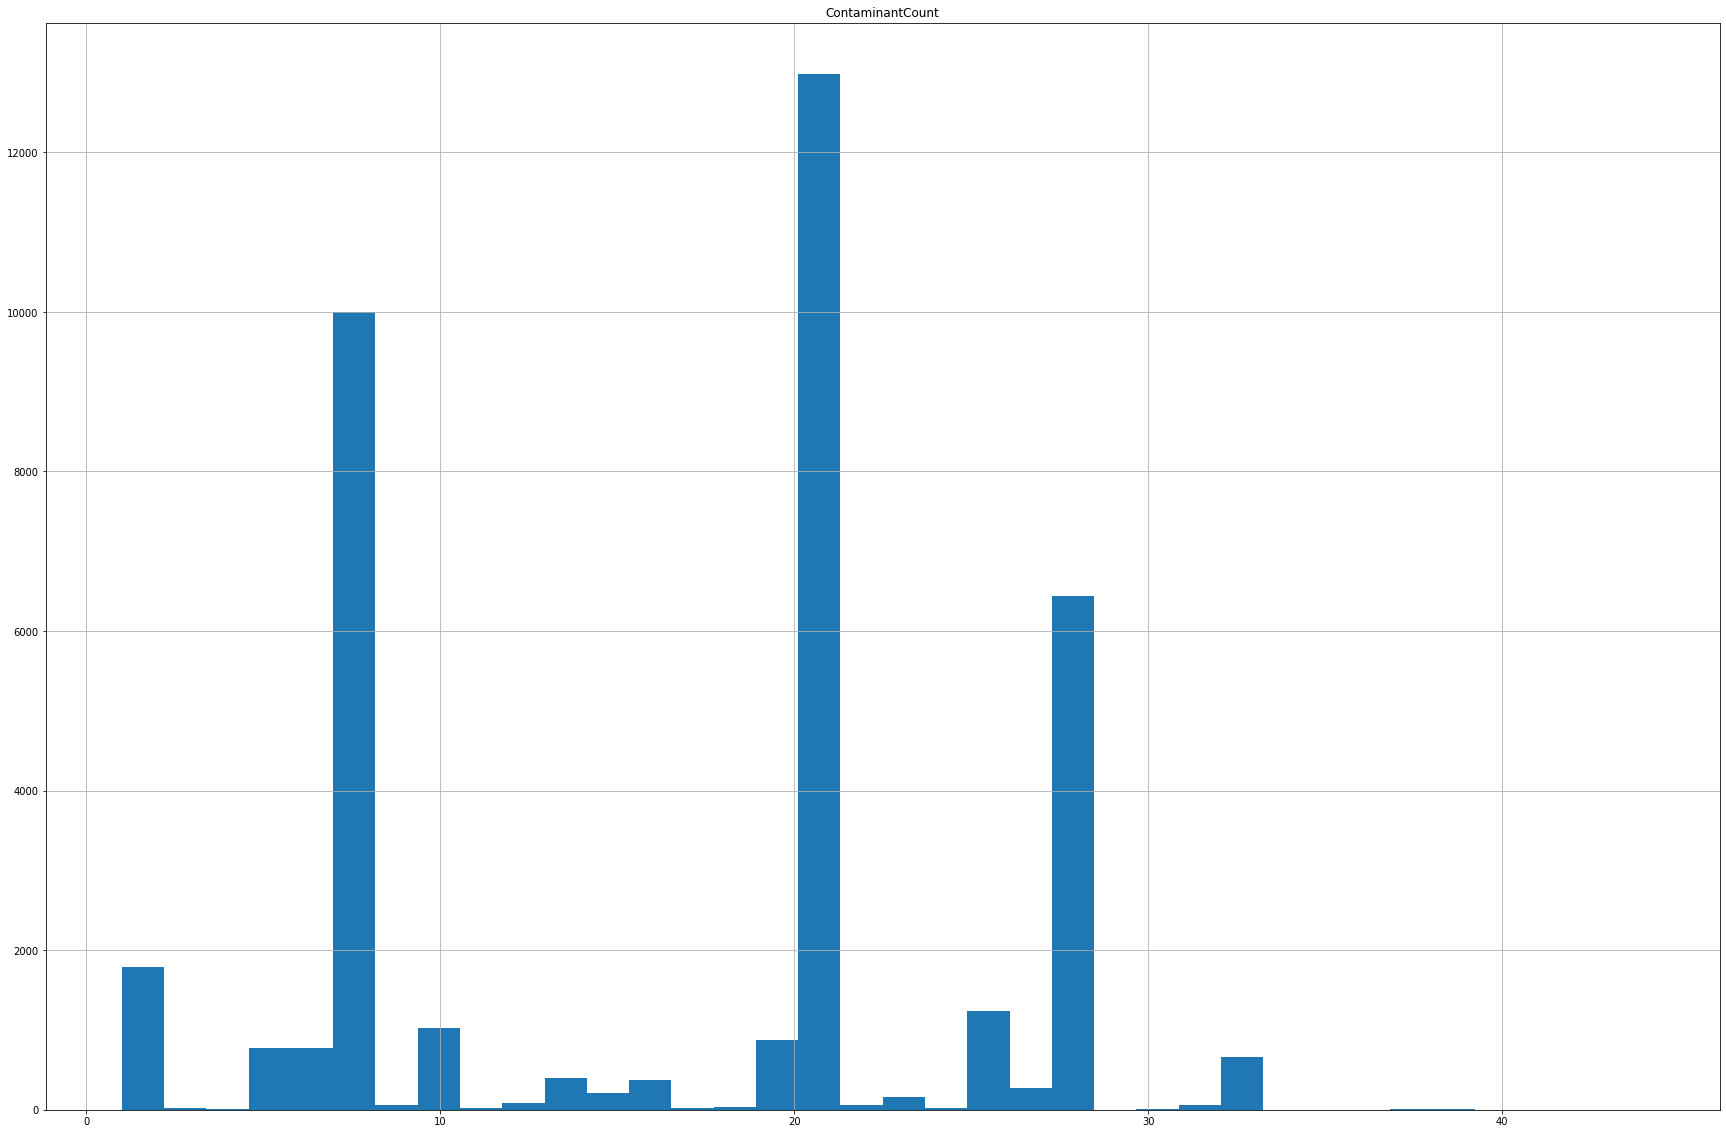

In [48]:
wc_cleaned["sampleId"] = wc_cleaned['State'] + '_' + wc_cleaned["FacilityID"].astype(str) + '_' + wc_cleaned["CollectionDate"].astype(str)
wc_graph = wc_cleaned.copy()
wc_graph = wc_graph.drop(columns=["FacilityID","CollectionDate"])
wc_graph.hist(column='ContaminantCount', bins=len(wc_graph['ContaminantCount'].unique()))

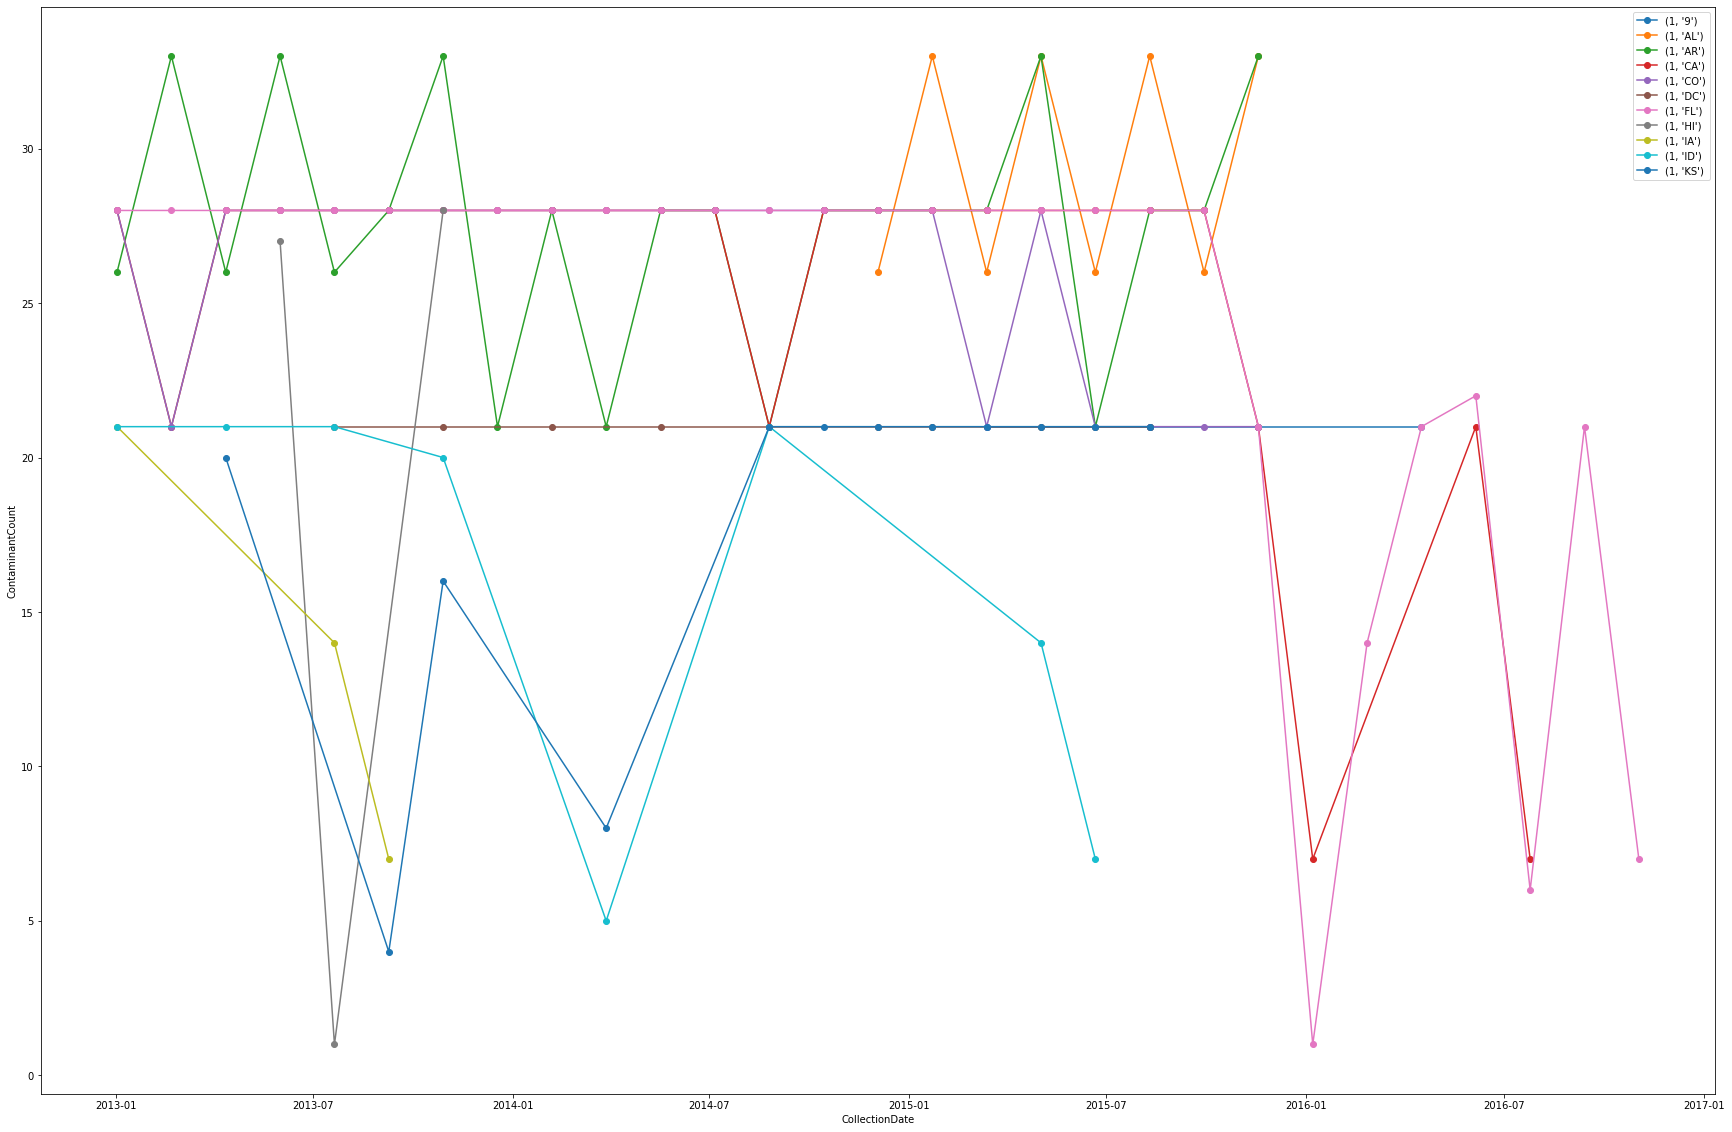

In [49]:
# Let's only plot the trend over time for a few facilities, as otherwise the plot becomes unreadable
groups = wc_cleaned.groupby(["FacilityID","State"])

for i, (name, group) in enumerate(groups):
    plt.plot(group["CollectionDate"], group["ContaminantCount"],"-o",label=name)
    if i==10: break
plt.legend()
plt.xlabel('CollectionDate')
plt.ylabel('ContaminantCount')
plt.show()

In [50]:
print(wc_cleaned['ContaminantCount'].describe())
print(wc.shape)

count    38414.000000
mean        16.889259
std          8.892323
min          1.000000
25%          7.000000
50%         21.000000
75%         21.000000
max         44.000000
Name: ContaminantCount, dtype: float64
(6194710, 11)


So now we know we have general contamination statistics per facility/collection event (of which there is a grand total of 12,447 events). We see an average of 17 contaminants per event. At max we see 44 contaminants, and the least we have seen is 1.

Next we will explore our fracking data set, after which we will look at both in conjunction - primarily, placement of fracking & facilities in terms of latitude/longitude.

## Fracking Data Set

From FracFocus, we have fracking data dating back as far as 1955. Since our EPA data is between 2014-2016, we'll want to filter out fracking set accordingly. 
```
Vrushalis-MacBook-Pro:ORIE4741 vrushalisamant$ grep -l '/2014' data/FracFocusRegistry_*.csv /dev/null
data/FracFocusRegistry_10.csv
data/FracFocusRegistry_11.csv
data/FracFocusRegistry_12.csv
data/FracFocusRegistry_13.csv
data/FracFocusRegistry_14.csv
data/FracFocusRegistry_15.csv
data/FracFocusRegistry_4.csv
data/FracFocusRegistry_5.csv
data/FracFocusRegistry_6.csv
data/FracFocusRegistry_7.csv
data/FracFocusRegistry_8.csv
data/FracFocusRegistry_9.csv
Vrushalis-MacBook-Pro:ORIE4741 vrushalisamant$ 
```
For now, we will pick out a single file and do some basic exploratory analysis on it.

In [51]:
f = read_file('FracFocusRegistry_4.csv')
f.head()

/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,UploadKey,JobStartDate,JobEndDate,APINumber,StateNumber,CountyNumber,OperatorName,WellName,Latitude,Longitude,...,IngredientKey,IngredientName,CASNumber,PercentHighAdditive,PercentHFJob,IngredientComment,IngredientMSDS,MassIngredient,ClaimantCompany,DisclosureKey
0,bc4b2b0e-b03e-4c29-a18c-300efc9b910a,10/9/2013 12:00:00 AM,10/16/2013 12:00:00 AM,42311353380000,42,311,BHP Billiton Petroleum,STS C7H,28.346298,-98.756096,...,945dd597-ebf3-417c-af83-1b2653ec3c84,"Tetrahydro-3,5-dimethyl-1,3,5-thiadiazine-2-th...",533-74-4,0.00000,0.00000,NaN,False,0.0,NaN,bc4b2b0e-b03e-4c29-a18c-300efc9b910a
1,bc4b2b0e-b03e-4c29-a18c-300efc9b910a,10/9/2013 12:00:00 AM,10/16/2013 12:00:00 AM,42311353380000,42,311,BHP Billiton Petroleum,STS C7H,28.346298,-98.756096,...,21ca22d6-cf3c-4a42-8547-c2550db51c97,"Sorbitan monooleate, ethoxylated",9005-65-6,0.00001,0.00000,NaN,False,0.0,NaN,bc4b2b0e-b03e-4c29-a18c-300efc9b910a
2,bc4b2b0e-b03e-4c29-a18c-300efc9b910a,10/9/2013 12:00:00 AM,10/16/2013 12:00:00 AM,42311353380000,42,311,BHP Billiton Petroleum,STS C7H,28.346298,-98.756096,...,7d978614-2e6e-48b3-9d44-c32ab51312a8,"Siloxanes and Silicones, di-Me, 3-hydroxypropy...",68937-55-3,0.00005,0.00001,NaN,False,0.0,NaN,bc4b2b0e-b03e-4c29-a18c-300efc9b910a
3,bc4b2b0e-b03e-4c29-a18c-300efc9b910a,10/9/2013 12:00:00 AM,10/16/2013 12:00:00 AM,42311353380000,42,311,BHP Billiton Petroleum,STS C7H,28.346298,-98.756096,...,f29b0695-e63c-46a5-8744-7fd7c386e3ce,"2-Propenoic acid, 2-ethylhexyl ester, polymer ...",36089-45-9,0.00005,0.00001,NaN,False,0.0,NaN,bc4b2b0e-b03e-4c29-a18c-300efc9b910a
4,bc4b2b0e-b03e-4c29-a18c-300efc9b910a,10/9/2013 12:00:00 AM,10/16/2013 12:00:00 AM,42311353380000,42,311,BHP Billiton Petroleum,STS C7H,28.346298,-98.756096,...,8dd662eb-a6b0-45d8-bf7d-bee8ae75b8bd,"Fatty acids, C18-unsatd., dimers, ethoxylated ...",68308-89-4,0.00005,0.00001,NaN,False,0.0,NaN,bc4b2b0e-b03e-4c29-a18c-300efc9b910a


In [52]:
def fracking_filter_years(f):
    f = convert_datetime(f, ['JobStartDate', 'JobEndDate'])
    f = f[(f['JobEndDate'].dt.year==2014) | (f['JobEndDate'].dt.year==2015) | (f['JobEndDate'].dt.year==2016)]
    return f

f = fracking_filter_years(f)
print('Columns: ' + str(f.columns))
print('Dimensions: ' + str(f.shape))
f.head()

Columns: Index(['UploadKey', 'JobStartDate', 'JobEndDate', 'APINumber', 'StateNumber',
       'CountyNumber', 'OperatorName', 'WellName', 'Latitude', 'Longitude',
       'Projection', 'TVD', 'TotalBaseWaterVolume', 'TotalBaseNonWaterVolume',
       'StateName', 'CountyName', 'FFVersion', 'FederalWell', 'IndianWell',
       'Source', 'DTMOD', 'PurposeKey', 'TradeName', 'Supplier', 'Purpose',
       'SystemApproach', 'IsWater', 'PurposePercentHFJob',
       'PurposeIngredientMSDS', 'IngredientKey', 'IngredientName', 'CASNumber',
       'PercentHighAdditive', 'PercentHFJob', 'IngredientComment',
       'IngredientMSDS', 'MassIngredient', 'ClaimantCompany', 'DisclosureKey'],
      dtype='object')
Dimensions: (40162, 39)


,UploadKey,JobStartDate,JobEndDate,APINumber,StateNumber,CountyNumber,OperatorName,WellName,Latitude,Longitude,...,IngredientKey,IngredientName,CASNumber,PercentHighAdditive,PercentHFJob,IngredientComment,IngredientMSDS,MassIngredient,ClaimantCompany,DisclosureKey
209838,7844525b-ea90-4c60-8321-3793d97d9d1b,2013-12-30,2014-01-01,4030488820000,4,30,Occidental Oil and Gas,385H H 8H,35.152525,-119.316428,...,cdb80773-9c4f-44cf-8d20-a8b73416072c,Sulfonate,Confidential,10.0,0.004474,NaN,True,120.0,NaN,7844525b-ea90-4c60-8321-3793d97d9d1b
209839,7844525b-ea90-4c60-8321-3793d97d9d1b,2013-12-30,2014-01-01,4030488820000,4,30,Occidental Oil and Gas,385H H 8H,35.152525,-119.316428,...,ef9ef46c-4c0f-4258-ba00-ea34344df0e8,Methanol,67-56-1,100.0,0.044743,NaN,True,1191.0,NaN,7844525b-ea90-4c60-8321-3793d97d9d1b
209840,7844525b-ea90-4c60-8321-3793d97d9d1b,2013-12-30,2014-01-01,4030488820000,4,30,Occidental Oil and Gas,385H H 8H,35.152525,-119.316428,...,b6c07388-f9f5-4823-b23a-47db2a544093,EDTA/Copper chelate,Confidential,30.0,0.009459,NaN,True,252.0,NaN,7844525b-ea90-4c60-8321-3793d97d9d1b
209841,7844525b-ea90-4c60-8321-3793d97d9d1b,2013-12-30,2014-01-01,4030488820000,4,30,Occidental Oil and Gas,385H H 8H,35.152525,-119.316428,...,b37ff72e-de8a-40a2-9631-00813a783732,"Bentonite, benzyl(hydrogenated tallow alkyl) d...",121888-68-4,0.0,0.014852,NaN,False,396.0,NaN,7844525b-ea90-4c60-8321-3793d97d9d1b
209842,7844525b-ea90-4c60-8321-3793d97d9d1b,2013-12-30,2014-01-01,4030488820000,4,30,Occidental Oil and Gas,385H H 8H,35.152525,-119.316428,...,3c0493a6-1e80-4fa1-a3f6-c2fc31c0cb1d,Fatty acid tall oil amide,Confidential,0.0,0.000083,NaN,False,3.0,NaN,7844525b-ea90-4c60-8321-3793d97d9d1b


We can pause for a brief summary of the columns (ones in bold are ones we are keeping):
<ul>
<li><b>JobStartDate/JobEndDate</b> - start/end date of the hydraulic fracking job</li>
<li>APINumber - The American Petroleum Institute well identification number formatted as follows xx-xxx-xxxxx0000 Where: First two digits represent the state, second three digits represent the county, third 5 digits represent the well.</li>
<li>StateNumber - The first two digits of the API number.  Range is from 01-50.</li>
<li>CountyNumber - The 3 digit county code.</li>
<li>OperatorName - The name of the operator.</li>
<li>WellName - The name of the well.</li>
<li><b>Latitude/Longitude</b> - self-explanatory, but key</li>
<li>Projection - The geographic coordinate system to which the latitude and longitude are related. In the FracFocus system the projection systems allowed are NAD (North American Datum) 27 or 83 and UTM (Universal Transverse Mercator).</li>
<li><b>TVD</b> - The vertical distance from a point in the well (usually the current or final depth) to a point at the surface, usually the elevation of the rotary kelly bushing.</li>
<li><b>TotalBaseWaterVolume</b> - The total volume of water used as a carrier fluid for the hydraulic fracturing job (in gallons).</li>
<li>StateName - The name of the state where the surface location of the well resides.  Calculated from the API number.</li>
<li>CountyName - The name of the county were the surface location of the well resides.  Calculated from the API number.</li>
<li><b>TotalBaseNonWaterVolume</b> - The total volume of non water components used as a carrier fluid for the hydraulic fracturing job (in gallons)</li>
<li><b>FFVersion</b> - A key which designates which version of FracFocus was used when the disclosure was submitted.</li>
<li><b>FederalWell</b> - True = Yes, False = No.</li>
<li><b>TradeName</b> - The name of the product as defined by the supplier.</li>
<li><b>Supplier</b> - The name of the company that supplied the product for the hydraulic fracturing job (Usually the service company).</li>
<li><b>Purpose</b> - The reason the product was used (e.g. Surfactant, Biocide, Proppant).</li>
<li><b>IngredientName</b> - Name of the chemical or for Trade Secret chemicals the chemical family name.</li>
<li><b>CASNumber</b> - The Chemical Abstract Service identification number.</li>
<li><b>PercentHighAdditive</b> - The percent of the ingredient in the Trade Name product in % (Top of the range from MSDS).</li>
<li><b>PercentHFJob</b> - The amount of the ingredient in the total hydraulic fracturing volume in % by Mass.</li>
</ul>

In [53]:
def fracking_filter_columns(f):
    return f[['JobStartDate', 'JobEndDate', 'Latitude', 'Longitude', 'TVD', 'TotalBaseWaterVolume',
       'TotalBaseNonWaterVolume', 'FFVersion', 'FederalWell', 'TradeName', 'Supplier',
       'Purpose', 'IngredientName', 'CASNumber', 'PercentHighAdditive', 'PercentHFJob','StateName']]

def fracking_get_job_duration(f):
    f['JobDuration'] = (f.JobEndDate - f.JobStartDate) / pd.Timedelta(days=1)
    return f

def get_fracking_data():
    frames = []
    for i in range(4,16):
        df = read_file('FracFocusRegistry_{}.csv'.format(i))
        df = fracking_filter_years(df)
        df = fracking_filter_columns(df)
        frames.append(df.reset_index())
    df = pd.concat(frames).reset_index()
    df = fracking_get_job_duration(df)
    return df

df_f = get_fracking_data()
print(df_f.shape)

/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (37) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (35,37) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (37) have mixed types.Specify dtype option on import or set low_memory=False

(2091769, 20)


[]

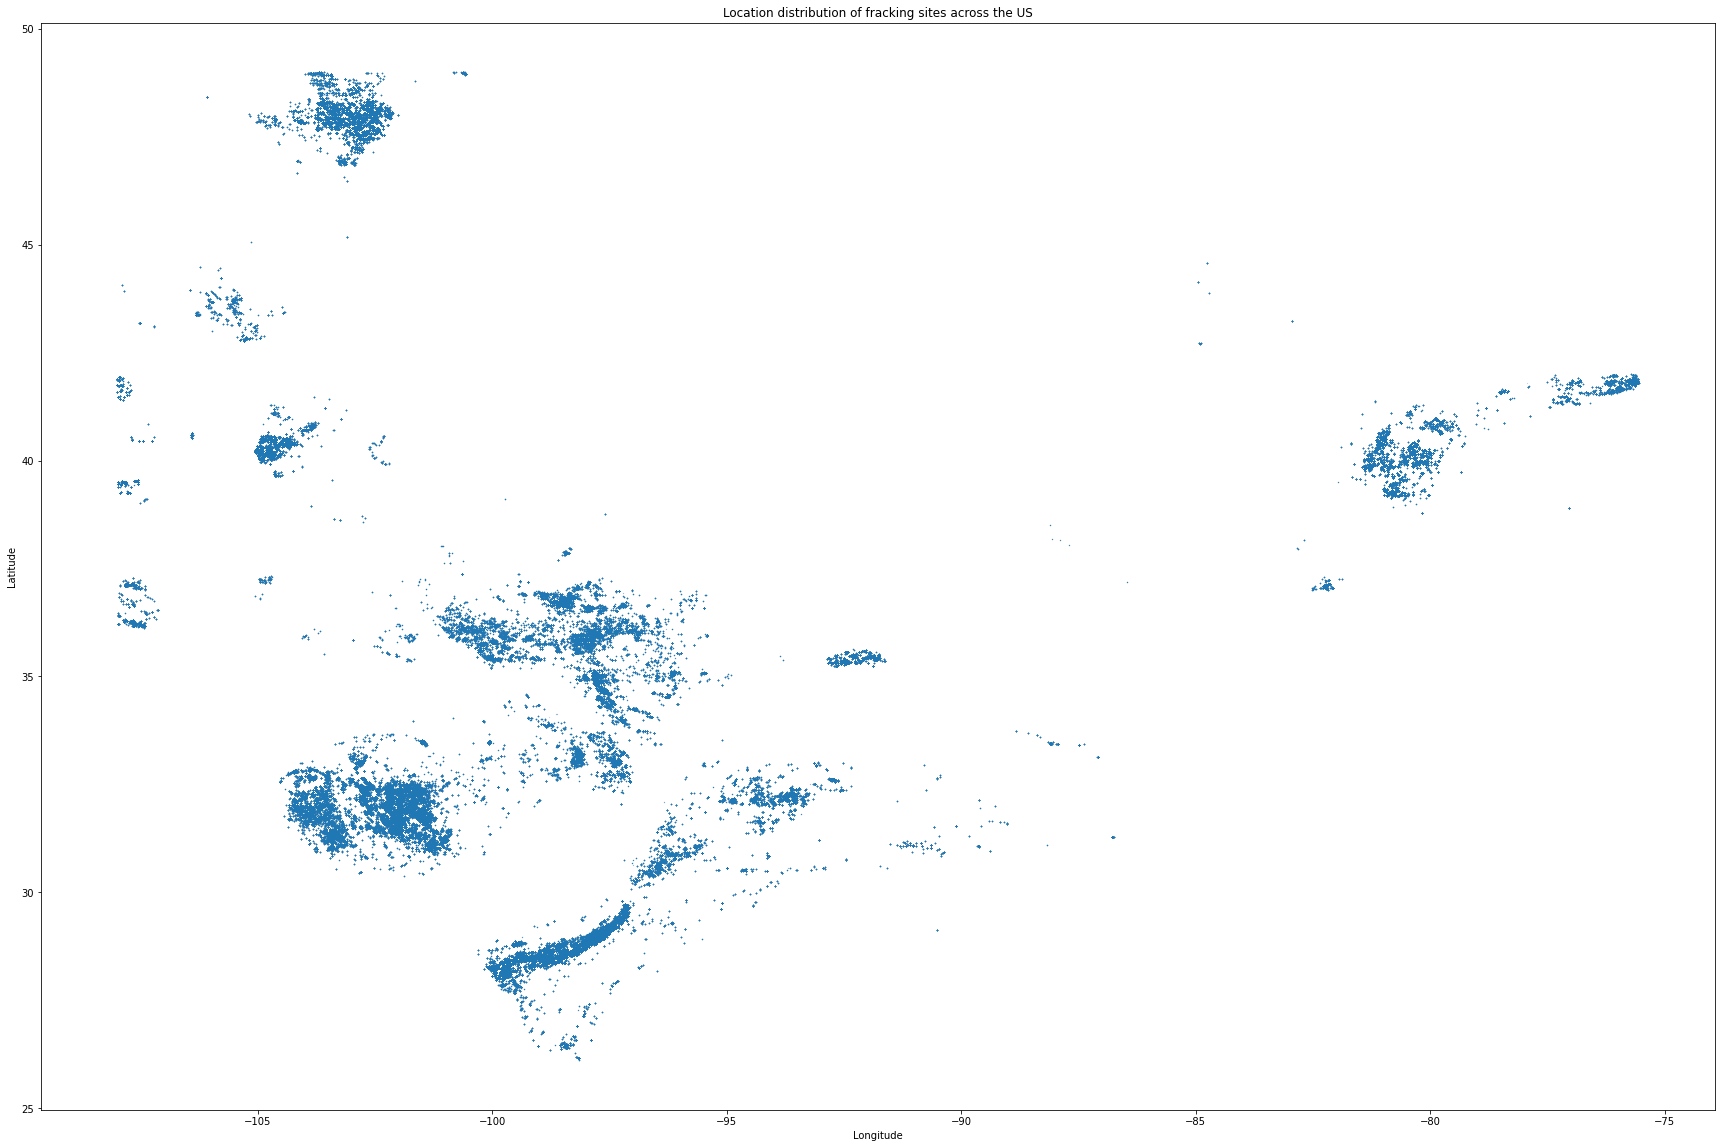

In [19]:
def filter_lat_long(f):
    '''We see in some cases numbers like "376223","3810848" being reported
       for latitude/longitude which is wrong'''
    return f[(f['Latitude'] > -90) & (f['Latitude']<90) & (f['Longitude']>-108) & (f['Longitude']<-60)]

f_lat_long = filter_lat_long(df_f)

f_lat_long = f_lat_long.dropna(subset=["Latitude", "Longitude"])
plt.scatter(f_lat_long["Longitude"],f_lat_long["Latitude"],s=0.01)
plt.title("Location distribution of fracking sites across the US")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.plot()

In general, we see hotspots are Texas, the upper North-East, and Alaska. Let's layer this with out contamination data.

Tier size: 8.8


[]

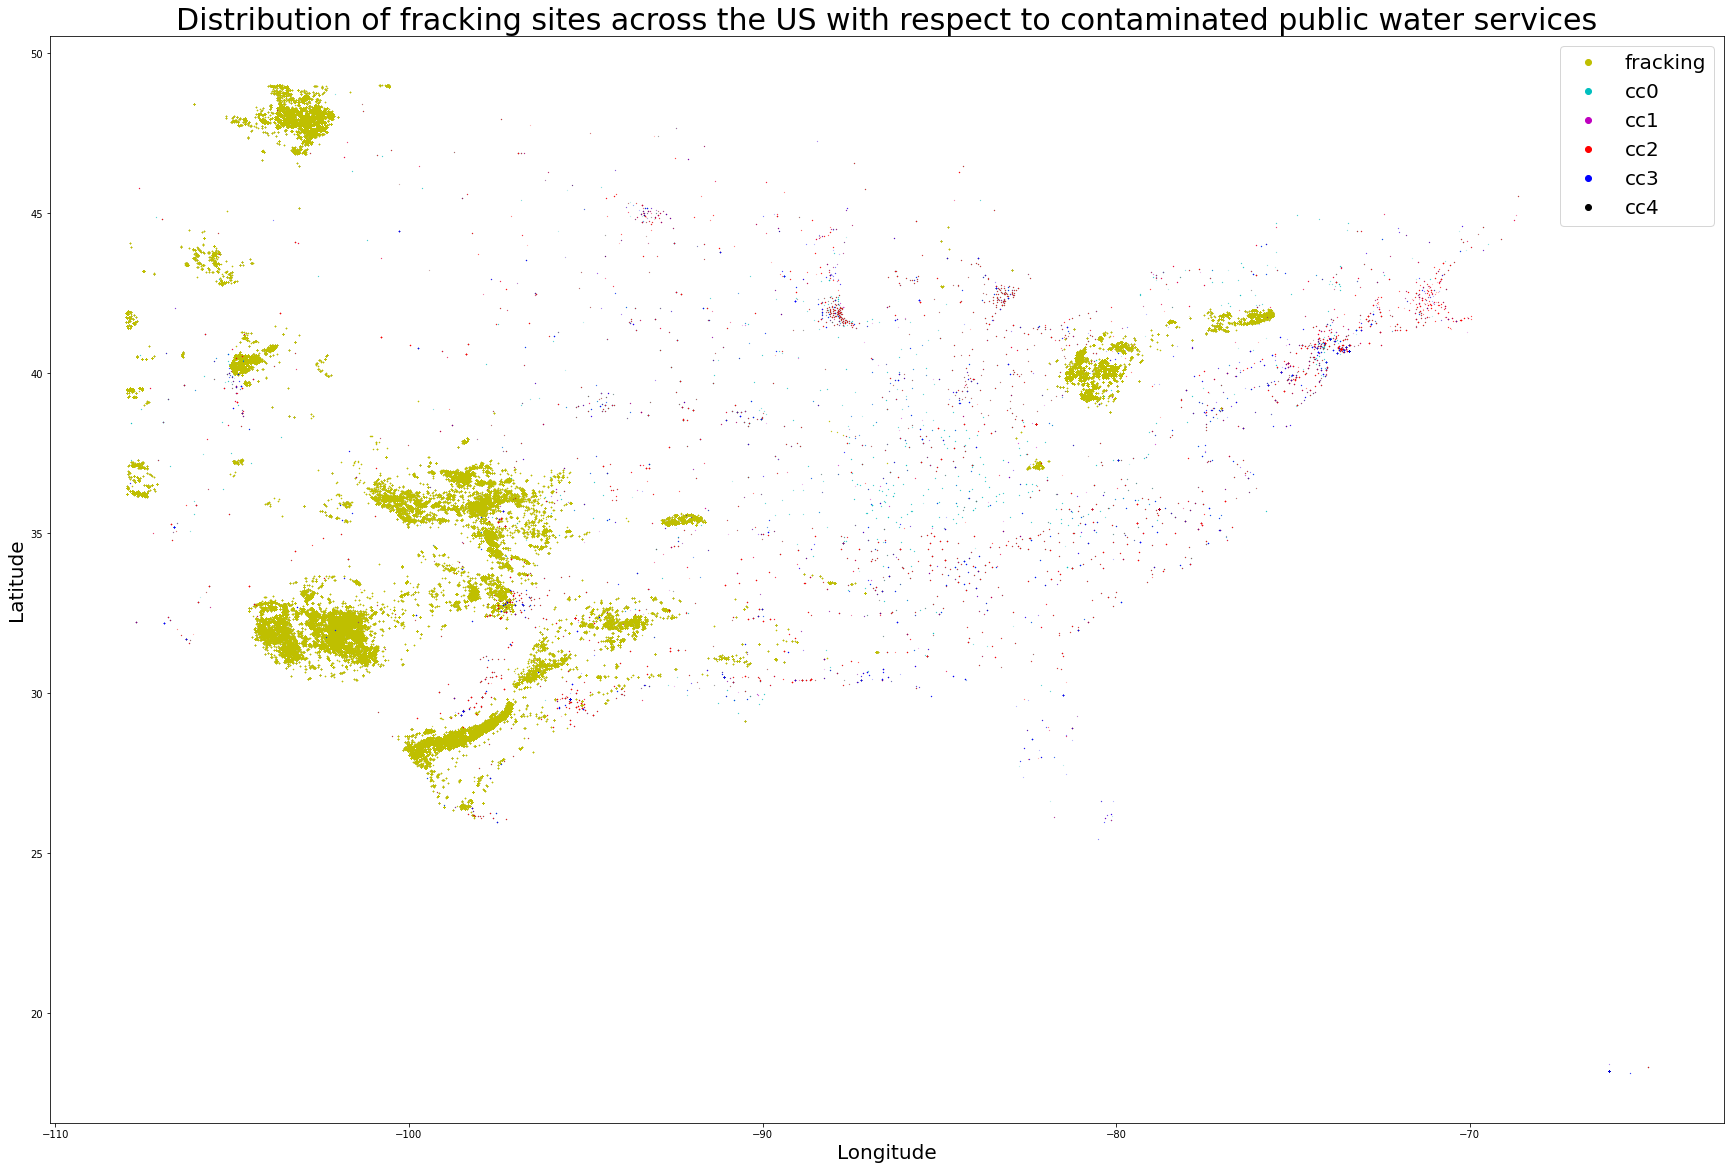

In [54]:
wc_lat_long = filter_lat_long(wc_cleaned)
f2_lat_long = f_lat_long

colors = ['c','m','r', 'b','k']
legend = []
chunk_size = wc_lat_long.ContaminantCount.max()/5.0
print('Tier size: {}'.format(chunk_size))
tier_counts = {}
start = 0
end = chunk_size
plot = plt.scatter(f2_lat_long["Longitude"],f2_lat_long["Latitude"],s=0.01, color='y', label='fracking')
legend.append('fracking')
for i in range(5):
    wc_range_group = wc_lat_long[(wc_lat_long['ContaminantCount']>=start) & (wc_lat_long['ContaminantCount']<end)]
    plot = plt.scatter(wc_range_group['Longitude'],wc_range_group['Latitude'], color=colors[i],s=0.01)
    legend.append('cc{}'.format(i))
    tier_counts[i] = wc_range_group.shape[0]
    start += chunk_size
    end += chunk_size
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in ['y']+colors]
plt.gca().legend(markers, tuple(legend),fontsize=20)
plt.title("Distribution of fracking sites across the US with respect to contaminated public water services",fontsize=30)
plt.xlabel("Longitude",fontsize=20)
plt.ylabel("Latitude",fontsize=20)
plt.plot()

This graph shows us several key things. All yelow points are fracking sites. Other points (cc0-cc4) are organized by number of contaminants. Given that our chunk size is 6.6, we have the following categories -
<ol>
<li>cc0: 0-6 contaminants</li>
<li>cc1: 7-13 contaminants</li>
<li>cc2: 14-19 contaminants</li>
<li>cc3: 20-26 contaminants</li>
<li>cc4: 26 contaminants and above</li>
</ol>

We appear to have more contaminants in the North-East despite significantly fewer fracking sites than in Texas.
There is not always a strong correlation between fracking sites and contamination simply due to the distribution of fracking sites, which are evidently more densely located in less populous areas like Alaska where public water systems are fewer and far between.

Our model should be built to take into account regional differences like the one noted above.

(38414, 13)
(25229, 13)


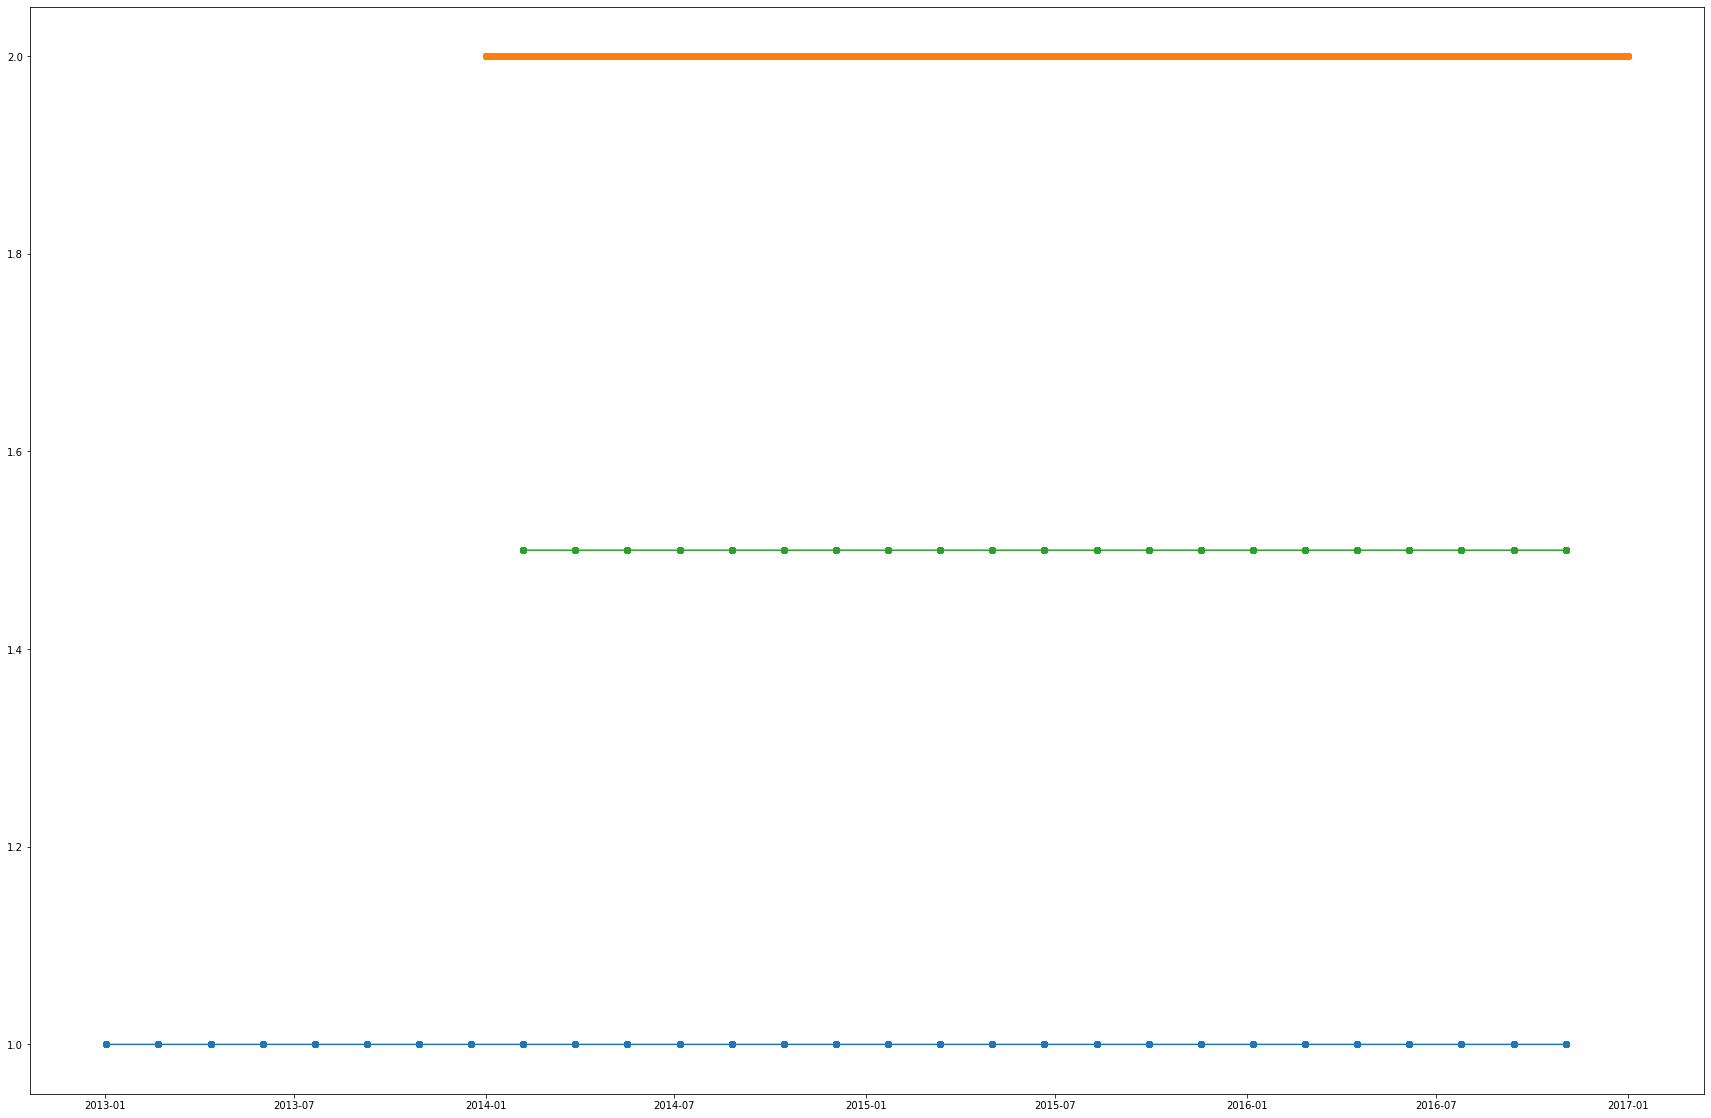

In [55]:
plt.plot(wc_cleaned["CollectionDate"], [1]*wc_cleaned.shape[0],"-o",label='State')
plt.plot(f_lat_long['JobEndDate'], [2]*f_lat_long.shape[0], "-o", label='State')
mindate = f_lat_long['JobEndDate'].min()
print(wc_cleaned.shape)
wc_ready = wc_cleaned[wc_cleaned['CollectionDate'] > mindate]
print(wc_ready.shape)
plt.plot(wc_ready["CollectionDate"], [1.5]*wc_ready.shape[0],"-o",label='State')


plt.show()

From the above graph we have an idea of how we can time-slice our data.

We can iterate from our first PWS (public water system) sample collection date (which have been grouped nicely as seen above) to our last. On each iteration, for every contamination data point, we want to find the nearest fracking site. The result of these iterations will be a dataframe mapping a contamination site event corresponding to the nearest fracking site given that the fracking job ended prior to the date of PWS sample collection. 

Given that fracking sites/sample sites can be revisited over time, our mapping can be 
(CollectionDate x Latitude x Longitude) x (JobEndDate x Latitude x Longitude)

Of course our fracking data at this point in time contains multiple entries for any given (JobEndDate x Latitude x Longitude) due to various different properties of the job, and we will deal with this in the next step when we create our final dataset, enriched with fracking data.

In [56]:
print(f_lat_long.columns)



Index(['level_0', 'index', 'JobStartDate', 'JobEndDate', 'Latitude',
       'Longitude', 'TVD', 'TotalBaseWaterVolume', 'TotalBaseNonWaterVolume',
       'FFVersion', 'FederalWell', 'TradeName', 'Supplier', 'Purpose',
       'IngredientName', 'CASNumber', 'PercentHighAdditive', 'PercentHFJob',
       'StateName', 'JobDuration'],
      dtype='object')


In [65]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import BallTree

def generate_dists(lat, long):
    return gpd.GeoDataFrame({
            'geometry': Point(a, b),
            'x': a,
            'y': b,
        } for a, b in zip(lat, long))

def group_f_subset(df):
    # it can be that multiple fracking sites are reported as separate entries even
    # though they have the same end date. For these, we will want to group them
    # as follows
    return df.groupby(['Latitude','Longitude','JobEndDate']).agg({'PercentHighAdditive': 'mean',
                                                                  'PercentHFJob': 'mean',
                                                                  'IngredientName': lambda x: tuple(set(x)),
                                                                  'Purpose': lambda x: tuple(set(x)),
                                                                  'Supplier': lambda x: tuple(set(x)),
                                                                  'JobDuration':'mean',
                                                                  'TotalBaseWaterVolume': 'mean',
                                                                  'TotalBaseNonWaterVolume': 'mean',
                                                                 }).reset_index()
wcs = []
collection_dates = wc_ready.CollectionDate.unique()
for cd in collection_dates:
    f_subset = group_f_subset(f_lat_long[f_lat_long['JobEndDate'] < cd].reset_index(drop=True))
    wc_subset = wc_ready[wc_ready['CollectionDate']==cd].reset_index(drop=True)
    wc_subset = wc_subset.rename(columns={'Latitude': 'LatitudePWS', 
                                          'Longitude': 'LongitudePWS'})
    f_subset = f_subset.rename(columns={'Latitude': 'LatitudeFracking', 
                                        'Longitude': 'LongitudeFracking'})
    wcd = generate_dists(wc_subset['LatitudePWS'], wc_subset['LongitudePWS'])
    fd = generate_dists(f_subset['LatitudeFracking'], f_subset['LongitudeFracking'])
    tree = BallTree(fd[['x', 'y']].values, leaf_size=2)
    wcd['distance_nearest'], wcd['id_nearest'] = tree.query(
        wcd[['x', 'y']].values, # The input array for the query
        k=1, # The number of nearest neighbors
    )
    wcd_enriched = wcd.merge(f_subset, left_on='id_nearest', right_index=True, how='left')

    wcd_enriched = wcd_enriched.merge(wc_subset, how='left', left_on=['x','y'],
                                      right_on=['LatitudePWS','LongitudePWS'])
    wcd_enriched = wcd_enriched.drop(['x', 'y', 'IsContaminated', 'level_0',
                                      'id_nearest', 'sampleId'], axis=1)
    wcs.append(wcd_enriched)

wc_processed = pd.concat(wcs)
wc_processed.to_csv("data/contamination_fracking.csv", sep=",")
print(wc_processed.shape)
print(wc_processed.columns)


wc_processed

(200905, 23)
Index(['geometry', 'distance_nearest', 'LatitudeFracking', 'LongitudeFracking',
       'JobEndDate', 'PercentHighAdditive', 'PercentHFJob', 'IngredientName',
       'Purpose', 'Supplier', 'JobDuration', 'TotalBaseWaterVolume',
       'TotalBaseNonWaterVolume', 'CollectionDate', 'FacilityID', 'State',
       'ContaminantCount', 'index', 'FacilityWaterType', 'Zip', 'LatitudePWS',
       'LongitudePWS', 'SizeBool'],
      dtype='object')


,geometry,distance_nearest,LatitudeFracking,LongitudeFracking,JobEndDate,PercentHighAdditive,PercentHFJob,IngredientName,Purpose,Supplier,...,CollectionDate,FacilityID,State,ContaminantCount,index,FacilityWaterType,Zip,LatitudePWS,LongitudePWS,SizeBool
0,POINT (35.137 -90.286),1.732584,35.407575,-91.996927,2014-01-20,49.315789,5.264262,"(Hydrogen Chloride, Organic Phosphate Ester Sa...","(Hydrochloric Acid, Biocide, Acid Corrosion In...","(XTO, Nalco, Halliburton)",...,2014-02-06,1,AR,28,139086,GW,72303,35.137366,-90.285543,0
1,POINT (35.137 -90.286),1.732584,35.407575,-91.996927,2014-01-20,49.315789,5.264262,"(Hydrogen Chloride, Organic Phosphate Ester Sa...","(Hydrochloric Acid, Biocide, Acid Corrosion In...","(XTO, Nalco, Halliburton)",...,2014-02-06,3,AR,26,139103,GW,72303,35.137366,-90.285543,0
2,POINT (33.787 -118.299),11.066041,36.200230,-107.499050,2014-02-02,30.000000,1.729810,"(Naphthalene, Ammonium Persulphate, Calcined D...","(Gelling Agent, Clay Control, Biocide, Other C...","(Baker Hughes, Other Chemicals, Operator)",...,2014-02-06,1,CA,28,67540,SW,91802,33.786594,-118.298662,0
3,POINT (40.586 -105.105),0.197305,40.552116,-104.910616,2014-02-03,26.291429,2.862506,"(Organic Polyol, Demineralized Water, Iron Oxi...","(Surfactants & Foamers, Clay Control Additives...","(Bayswater Exploration and Production, Nabors ...",...,2014-02-06,1,CO,28,86403,SW,80521,40.586282,-105.104940,0
4,POINT (40.586 -105.105),0.197305,40.552116,-104.910616,2014-02-03,26.291429,2.862506,"(Organic Polyol, Demineralized Water, Iron Oxi...","(Surfactants & Foamers, Clay Control Additives...","(Bayswater Exploration and Production, Nabors ...",...,2014-02-06,6965,CO,7,106767,SW,80521,40.586282,-105.104940,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,POINT (42.196 -71.438),4.136751,41.795561,-75.555288,2015-06-12,21.795455,4.532728,"(Diethanolamine, Ammonium Chloride, Cocamide D...","(Biocide, Friction Reducer, Proppant, Acidizin...","(TSS, Chemplex, Operator, Reagent)",...,2016-11-02,2,MA,16,75185,GW,1746,42.196065,-71.437970,0
1275,POINT (42.196 -71.438),4.136751,41.795561,-75.555288,2015-06-12,21.795455,4.532728,"(Diethanolamine, Ammonium Chloride, Cocamide D...","(Biocide, Friction Reducer, Proppant, Acidizin...","(TSS, Chemplex, Operator, Reagent)",...,2016-11-02,4,MA,21,75198,GW,1746,42.196065,-71.437970,0
1276,POINT (42.196 -71.438),4.136751,41.795561,-75.555288,2015-06-12,21.795455,4.532728,"(Diethanolamine, Ammonium Chloride, Cocamide D...","(Biocide, Friction Reducer, Proppant, Acidizin...","(TSS, Chemplex, Operator, Reagent)",...,2016-11-02,5,MA,21,75098,GW,1746,42.196065,-71.437970,0
1277,POINT (42.196 -71.438),4.136751,41.795561,-75.555288,2015-06-12,21.795455,4.532728,"(Diethanolamine, Ammonium Chloride, Cocamide D...","(Biocide, Friction Reducer, Proppant, Acidizin...","(TSS, Chemplex, Operator, Reagent)",...,2016-11-02,6,MA,16,75081,GW,1746,42.196065,-71.437970,0


We've finally related our contamination and fracking datasets! We found the nearest fracking-site neighbor of a sample-site, and joined these corresponding entries together. If we wanted to iterate over this selection, we might find the k-nearest fracking-site neighbors of the sample-site and aggregate this information with respect to k.